RMSE_x = 2.015177965370781
RMSE_y = 1.9897881728309863
Saved: truth.csv, measurement.csv, meta.csv


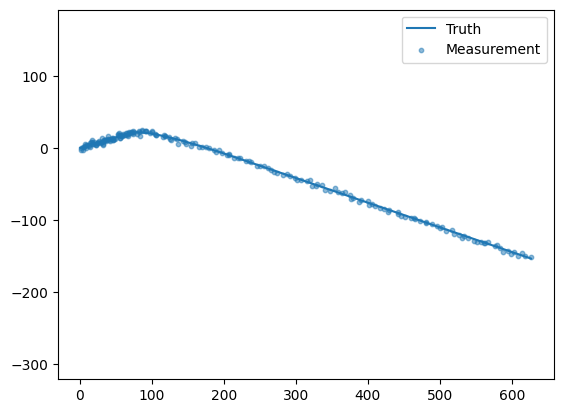

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Truth 생성
# 2D 운동: 처음엔 등속  중간 구간에 가속
def generate_truth(T=200, dt=1.0): # dt : 시간 간격

    px, py = 0.0, 0.0   # 초기 위치
    vx, vy = 1.0, 0.3   # 초기 속도
    ax, ay = 0.0, 0.0   # 초기 가속도

    truth = []

    for k in range(T):

        # 중간 구간에서 가속
        if 70 <= k <= 120:
            ax, ay = 0.08, -0.04
        else:
            ax, ay = 0.0, 0.0

        # 운동방정식
        px = px + vx * dt + 0.5 * ax * dt**2
        py = py + vy * dt + 0.5 * ay * dt**2

        vx = vx + ax * dt
        vy = vy + ay * dt

        truth.append([k, px, py, vx, vy, ax, ay])

    return np.array(truth)

# 2. Measurement 생성(위치에 가우시안 노이즈 추가)

def generate_measurement(truth, sigma=2.0,seed=2026):
    rng = np.random.default_rng(seed)
    meas = []

    for row in truth:
        k, px, py, *_ = row   # 센서의 측정이 위치만 이루어진다고 가정 -> (vx,vy,ax,ay)를 *_로 버림

        mx = px + np.random.normal(0, sigma)
        my = py + np.random.normal(0, sigma)

        meas.append([k, mx, my])

    return np.array(meas)

# 3. RMSE 계산 (디버깅용)  # truth와 meas의 위치 오차 평균 계산 sigma=2.0이므로 x,y의 RMSE가 2 근처여야 함

def compute_rmse_xy(truth, meas):
    # x 오차
    dx = truth[:,1] - meas[:,1]
    rmse_x = np.sqrt(np.mean(dx**2))

    # y 오차
    dy = truth[:,2] - meas[:,2]
    rmse_y = np.sqrt(np.mean(dy**2))

    return rmse_x, rmse_y


# 4. 실행

T = 200
truth = generate_truth(T)
meas = generate_measurement(truth, sigma=2.0)

rmse_x, rmse_y = compute_rmse_xy(truth, meas)

print("RMSE_x =", rmse_x)
print("RMSE_y =", rmse_y)


T = 200
dt = 1.0
sigma = 2.0
seed_meas = 2026

truth = generate_truth(T=T, dt=dt)
meas  = generate_measurement(truth, sigma=sigma, seed=seed_meas)

# CSV 저장
truth_df = pd.DataFrame(truth, columns=["k","px","py","vx","vy","ax","ay"])
meas_df  = pd.DataFrame(meas,  columns=["k","mx","my"])

truth_df.to_csv("truth.csv", index=False)
meas_df.to_csv("measurement.csv", index=False)

# 메타도 저장(선택이지만 C++에 도움 됨)
pd.DataFrame({"dt":[dt], "sigma_meas":[sigma], "seed_meas":[seed_meas]}).to_csv("meta.csv", index=False)

print("Saved: truth.csv, measurement.csv, meta.csv")

# 5. 시각화

plt.plot(truth[:,1], truth[:,2], label="Truth")
plt.scatter(meas[:,1], meas[:,2], s=10, alpha=0.5, label="Measurement")
plt.legend()
plt.axis("equal")
plt.show()


Saved: estimate_python.csv
Measurement RMSE : 2.0258763753854554
KF Estimate RMSE : 1.2362706207589922


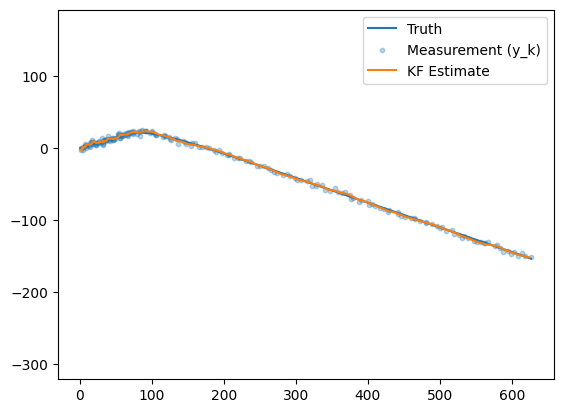

In [ ]:
# 1. CSV 로드

truth_df = pd.read_csv("truth.csv")
meas_df = pd.read_csv("measurement.csv")
meta_df  = pd.read_csv("meta.csv")

truth = truth_df[["px","py"]].values
y_meas = meas_df[["mx","my"]].values   # 관측값 y_k

T = len(y_meas)
dt = 1.0
sigma = float(meta_df["sigma_meas"].iloc[0])
# 2. 모델 행렬 정의

# 상태: x = [px, py, vx, vy]^T
A = np.array([[1,0,dt,0],
              [0,1,0,dt],
              [0,0,1,0],
              [0,0,0,1]],dtype=float)

H = np.array([[1,0,0,0],
              [0,1,0,0]],dtype=float)

Q = np.eye(4) * 0.01     # 프로세스 노이즈 공분산
R = np.eye(2) * 4.0      # 측정 노이즈 공분산 (sigma=2 → 2^2=4) np.eye() : 단위행렬(대각행렬)

# 3. 초기값 설정

x_hat = np.zeros((4,1))        # 초기 상태 추정
x_hat[0,0] = y_meas[0,0]       # 초기 위치는 첫 관측값으로
x_hat[1,0] = y_meas[0,1]

P = np.eye(4) * 10.0            # 초기 추정 오차 공분산
I = np.eye(4)

# 4. KF 반복

estimates = []

# k=0 시점의 초기 추정값을 먼저 저장 (업데이트 없이 초기값 그대로)
estimates.append(x_hat[:2].flatten())
for k in range(1,T):

    # ---- Predict 단계 ----
    x_pred = A @ x_hat
    P_pred = A @ P @ A.T + Q

    # ---- Update 단계 ----
    y_k = y_meas[k].reshape(2,1)

    # Innovation
    nu_k = y_k - H @ x_pred

    # Innovation covariance
    S_k = H @ P_pred @ H.T + R

    # Kalman Gain
    K_k = P_pred @ H.T @ np.linalg.inv(S_k)

    # 상태 업데이트
    x_hat = x_pred + K_k @ nu_k

    # 공분산 업데이트
    P = (I - K_k @ H) @ P_pred

    estimates.append(x_hat[:2].flatten())

estimates = np.array(estimates)

est_df = pd.DataFrame({
    "k": np.arange(T),
    "est_px": estimates[:,0],
    "est_py": estimates[:,1],
})
est_df.to_csv("estimate_python.csv", index=False)

print("Saved: estimate_python.csv")

# 5. RMSE 비교

def rmse(a,b):
    return np.sqrt(np.mean((a-b)**2))

rmse_meas = rmse(truth, y_meas)
rmse_kf   = rmse(truth, estimates)

print("Measurement RMSE :", rmse_meas)
print("KF Estimate RMSE :", rmse_kf)

# 6. 시각화

plt.plot(truth[:,0], truth[:,1], label="Truth")
plt.scatter(y_meas[:,0], y_meas[:,1], s=10, alpha=0.3, label="Measurement (y_k)")
plt.plot(estimates[:,0], estimates[:,1], label="KF Estimate")
plt.legend()
plt.axis("equal")
plt.show()


In [ ]:
# C++ 결과 로드
cpp_df = pd.read_csv("estimate_cpp.csv") # 경로 주의

# Python 결과와 비교 (소수점 정밀도 차이 감안)
diff_x = np.abs(est_df["est_px"] - cpp_df["est_px"])
diff_y = np.abs(est_df["est_py"] - cpp_df["est_py"])

print("Max difference X:", diff_x.max())
print("Max difference Y:", diff_y.max())

if diff_x.max() < 1e-5 and diff_y.max() < 1e-5:
    print("SUCCESS: Python and C++ implementations match!")
else:
    print("WARNING: Results differ significantly.")

Max difference X: 4.712492221971869
Max difference Y: 3.450143443229287


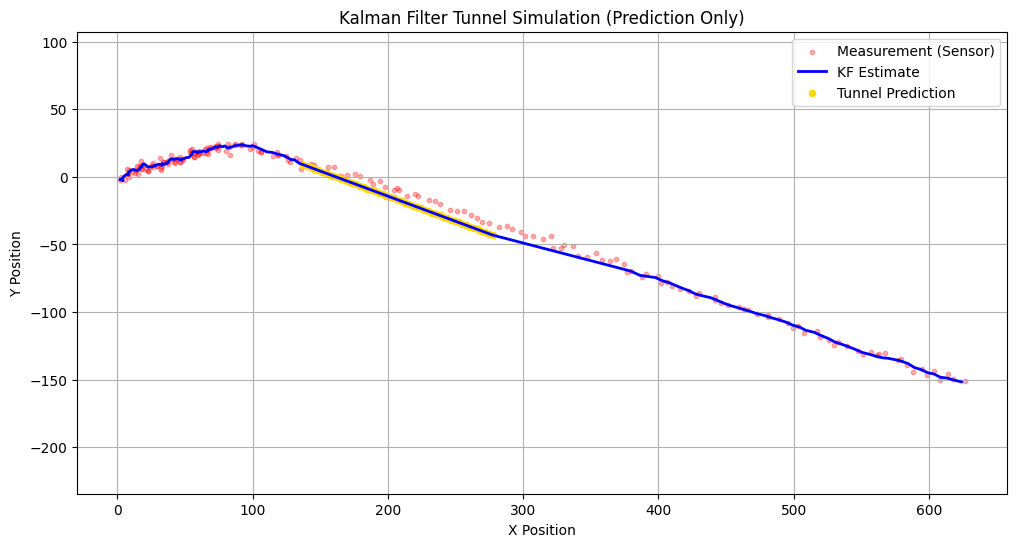

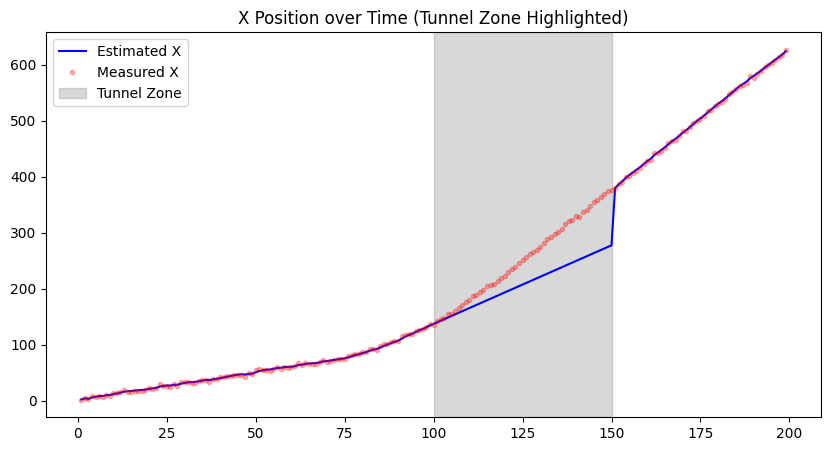

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 파일 로드
df = pd.read_csv("estimate_tunnel.csv")

# 2. 시각화
plt.figure(figsize=(12, 6))

# (1) 측정값 (빨간 점) - 센서는 계속 찍히지만 KF가 무시하는 구간
plt.scatter(df['mx'], df['my'], c='red', s=10, alpha=0.3, label='Measurement (Sensor)')

# (2) KF 추정값 (파란 선)
plt.plot(df['est_px'], df['est_py'], 'b-', linewidth=2, label='KF Estimate')

# (3) 터널 구간 표시 (k=100 ~ 150)
# 해당 구간의 좌표 범위를 찾아서 박스 그리기
tunnel_data = df[(df['k'] >= 100) & (df['k'] <= 150)]
if not tunnel_data.empty:
    # 터널 시작과 끝 지점 표시
    plt.scatter(tunnel_data['est_px'], tunnel_data['est_py'], c='gold', s=20, label='Tunnel Prediction')
    plt.title("Kalman Filter Tunnel Simulation (Prediction Only)")
else:
    plt.title("Kalman Filter Tracking")

plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.grid(True)
plt.axis('equal')
plt.show()

# 3. 확대해서 보기 (터널 구간만)
plt.figure(figsize=(10, 5))
plt.plot(df['k'], df['est_px'], 'b-', label='Estimated X')
plt.plot(df['k'], df['mx'], 'r.', alpha=0.3, label='Measured X')
plt.axvspan(100, 150, color='gray', alpha=0.3, label='Tunnel Zone') # 회색 영역
plt.title("X Position over Time (Tunnel Zone Highlighted)")
plt.legend()
plt.show()